In [1]:
import sys, os
import pathlib
import time
import importlib
import joblib
import pickle
from tqdm import tqdm

import numpy as np

from scipy.linalg import null_space
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import cv2

In [2]:
%load_ext autoreload
%autoreload 2

if not os.path.abspath("../") in sys.path:
    sys.path.append(os.path.abspath("../"))
    sys.path.append(os.path.abspath("../src"))

from src import normalization
from src import Camera, metashape_Camera
from src import camera_correspondence, FF_mat, epipole_angle, pair_and_key_gen, coll_dict_gen, pair_pt_gen
from src import FR_check, coordinate_dict_gen
from src import min_dist, tri, TDlines_gen, reprojection_gen, gen_support_dict, gen_support
from src import all_D, frag_list_fraged, all_sep

## パイプライン

In [5]:
occ = "q_a"
noise = "0mm"
individual = "q_1_a"
img_num = 64

In [7]:
cam_list = [Camera(i) for i in range(64)]
for i in range(len(cam_list)):
    cam_list[i].img_load("images/q_a/q_1_a/64")
    cam_list[i].contour_extraction()
    
    #cam_list[i].label_load("preprocessing/labels/{}_l/{}/{}/{}_{}_label.pickle".format(
    #        occ, noise, individual, individual, str(img_num)))
    #cam_list[i].correspondence_contour()
    
    cam_list[i].para_load("view_mats/q_e/view_mat_64/{}.csv".format(str(i)))


In [9]:
cam_list[i].img

[array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 

In [10]:
kernel = np.ones((3,3),np.uint8)

for cnum in range(len(cam_list)):
    sparse_mats_list = []
    for j in range(len(cam_list[cnum].contour_list)):
        new_img = np.zeros((cam_list[0].img[0].shape[0],cam_list[0].img[0].shape[1]),dtype=np.uint8)
        for i in range(len(cam_list[cnum].contour_list[j])):
            curve = cam_list[cnum].contour_list[j][i][~np.isnan(cam_list[cnum].contour_list[j][i])].reshape((-1,2)).astype(int)
            new_img[curve[:,1],curve[:,0]]=True
        dilation = cv2.dilate(new_img, kernel, iterations = 10)
        new_img = csr_matrix(dilation, dtype=np.uint8)
        sparse_mats_list.append(new_img)
        
    cam_list[cnum].contour_img = sparse_mats_list

In [12]:
# エピポール取得
cam_pairs = camera_correspondence(cam_list,angle_upper=30 / 180 * np.pi)

epipole_dict = {i:[] for i in range(len(cam_list))}
cam_pairs_F = {}
for i in cam_pairs:
    epipole1, epipole2, F = FF_mat(cam_list[i[0]].A, cam_list[i[1]].A, cam_list[i[0]].Rt, cam_list[i[1]].Rt)
    epipole_dict[i[0]].append(normalization(epipole1))
    epipole_dict[i[1]].append(normalization(epipole2))
    cam_pairs_F[i] = F
print(len(cam_pairs))

240


In [13]:
# フラグメントのリストを作る
for i in range(len(cam_list)):
    im_del_list = all_D(epipole_angle(i, epipole_dict, cam_list=cam_list))# im_del_list[color][contour][del_idx]
    newCon = all_sep(cam_list[i].contour_list, im_del_list)# newCon[color][fragment][coordination]
    cam_list[i].frag_list = frag_list_fraged(newCon)

del epipole_dict

C:\home\study\git_test\curve_sketch\src\epipolar.py:55: RuntimeWarning: invalid value encountered in double_scalars
  return list(map(lambda y: (y - min(B)) / (max(B) - min(B)), B))
C:\home\study\git_test\curve_sketch\src\epipolar.py:87: RuntimeWarning: divide by zero encountered in double_scalars
  tilt = (y - epi_y) / (x - epi_x)


In [14]:
#cnum = 4
#new_img = np.zeros((cam_list[0].img.shape[0],cam_list[0].img.shape[1]),dtype=np.bool8)
#
#for j in range(len(cam_list[cnum].frag_list)):
#    for i in range(len(cam_list[cnum].frag_list[j])):
#        curve = cam_list[cnum].frag_list[j][i][~np.isnan(cam_list[cnum].frag_list[j][i])].reshape((-1,2)).astype(int)
#        new_img[curve[:,1],curve[:,0]]=True

In [15]:
#%matplotlib inline
#fig = plt.figure(figsize = (20, 20))
#fig.patch.set_alpha(0.)
## 3DAxesを追加
#ax = fig.add_subplot(111)
#plt.imshow(new_img)

## ペア生成

In [16]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_and_key_gen)(i, cam_list, cam_pairs_F) for i in cam_pairs_F)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 3min 34s


In [17]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.pair_list"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [18]:
%%time
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coll_dict_gen)(i, cam_list, cam_pairs_F) for i in tags)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 3min 46s


In [19]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(pair_pt_gen)(i) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

In [20]:
_ = joblib.Parallel(n_jobs=-1, verbose=10)(joblib.delayed(coordinate_dict_gen)(i, cam_list=cam_list) for i in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

## 3次元再構築

In [21]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(TDlines_gen)(
    tag, cam_list=cam_list, cam_pairs_F=cam_pairs_F) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.3min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 2

In [22]:
%%time
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(reprojection_gen)(tag, cam_list=cam_list) for tag in tags)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed:  

Wall time: 5min 47s


In [23]:
temp_path = pathlib.Path("temp/")
tags_path = list(temp_path.glob("*.reprojection_dict"))

tags = []
for tag_path in tags_path:
    tag_sp = tag_path.stem.split("_")
    tag_arr = ((int(tag_sp[0]), int(tag_sp[1])), tag_sp[2])
    tags.append(tag_arr)

In [24]:
result = joblib.Parallel(n_jobs=-1,verbose=10)(joblib.delayed(gen_support)(tag, cam_list=cam_list) for tag in tags)
#4.1min finished

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  89 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 157 tasks      | elapsed: 34.9min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 197 tasks      | elapsed: 4

In [45]:
sup_th = 35# サポート数
curve_fragment = []
for tag in tags:
    if tag[1] == "R":
        continue
    
    with open(r"temp/{0}_{1}_{2}.TDlines".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        lines_list = pickle.load(f)
    #lines_list = TDlines[tag]
        
    with open(r"temp/{0}_{1}_{2}.support_dict".format(tag[0][0],tag[0][1],tag[1]), 'rb') as f:
        support_list, support_ac = pickle.load(f)
    #support_list, support_ac = support_dict[tag][0], support_dict[tag][1]
    tag_list = []
    for col, sup_col, ac_col in zip(lines_list, support_list, support_ac):
        col_curve_fragment = []
        for frag, sup, sup_ac in zip(col, sup_col, ac_col):
            if sup > sup_th:
                frag = np.reshape(frag,(-1, 3))
                frag = np.array([i for i,j in zip(frag, sup_ac >sup_th) if j])
                col_curve_fragment.append(frag)
        tag_list.append(col_curve_fragment)
    curve_fragment.append(tag_list)

In [46]:
cfs = [[],[],[],[],[],[],[],[],[]]
for cols in curve_fragment:
    for i in range(len(cols)):
        if i == 0:
            cfs[0] += cols[i]
        if i == 1:
            cfs[1] += cols[i]
        if i == 2:
            cfs[2] += cols[i]
        if i == 3:
            cfs[3] += cols[i]
        if i == 4:
            cfs[4] += cols[i]
        if i == 5:
            cfs[5] += cols[i]
        if i == 6:
            cfs[6] += cols[i]
        if i == 7:
            cfs[7] += cols[i]
        if i == 8:
            cfs[8] += cols[i]

In [47]:
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

def plot_graph():
    color_arr = np.array([[255,0,0],[0,255,0],[0,0,255],
                             [255,255,0],[255,0,255],[0,255,255],
                             [127,127,127],[127,0,127],[0,127,127]],dtype = np.int16)
    j = 0
    for i in range(len(cfs)):
        for frag in cfs[i]:
            if i != 6:
                continue
            
            if frag.size < 10:
                continue
            #print(frag)
            
            
            x = frag[:,0]
            y = frag[:,1]
            z = frag[:,2]
            data = [x,y,z]
            try:
                tck, u= interpolate.splprep(data, k=3)
            except ValueError:
                pass
            except TypeError:
                pass
            except UnboundLocalError:
                pass
            new = interpolate.splev(u, tck, der=0)
            c = color_arr[i]/255
            if j % 1 == 0:
                ax.plot(new[0], new[2], new[1],"-",color=c)
            
            j+=1


In [48]:
%matplotlib notebook

<IPython.core.display.Javascript object>


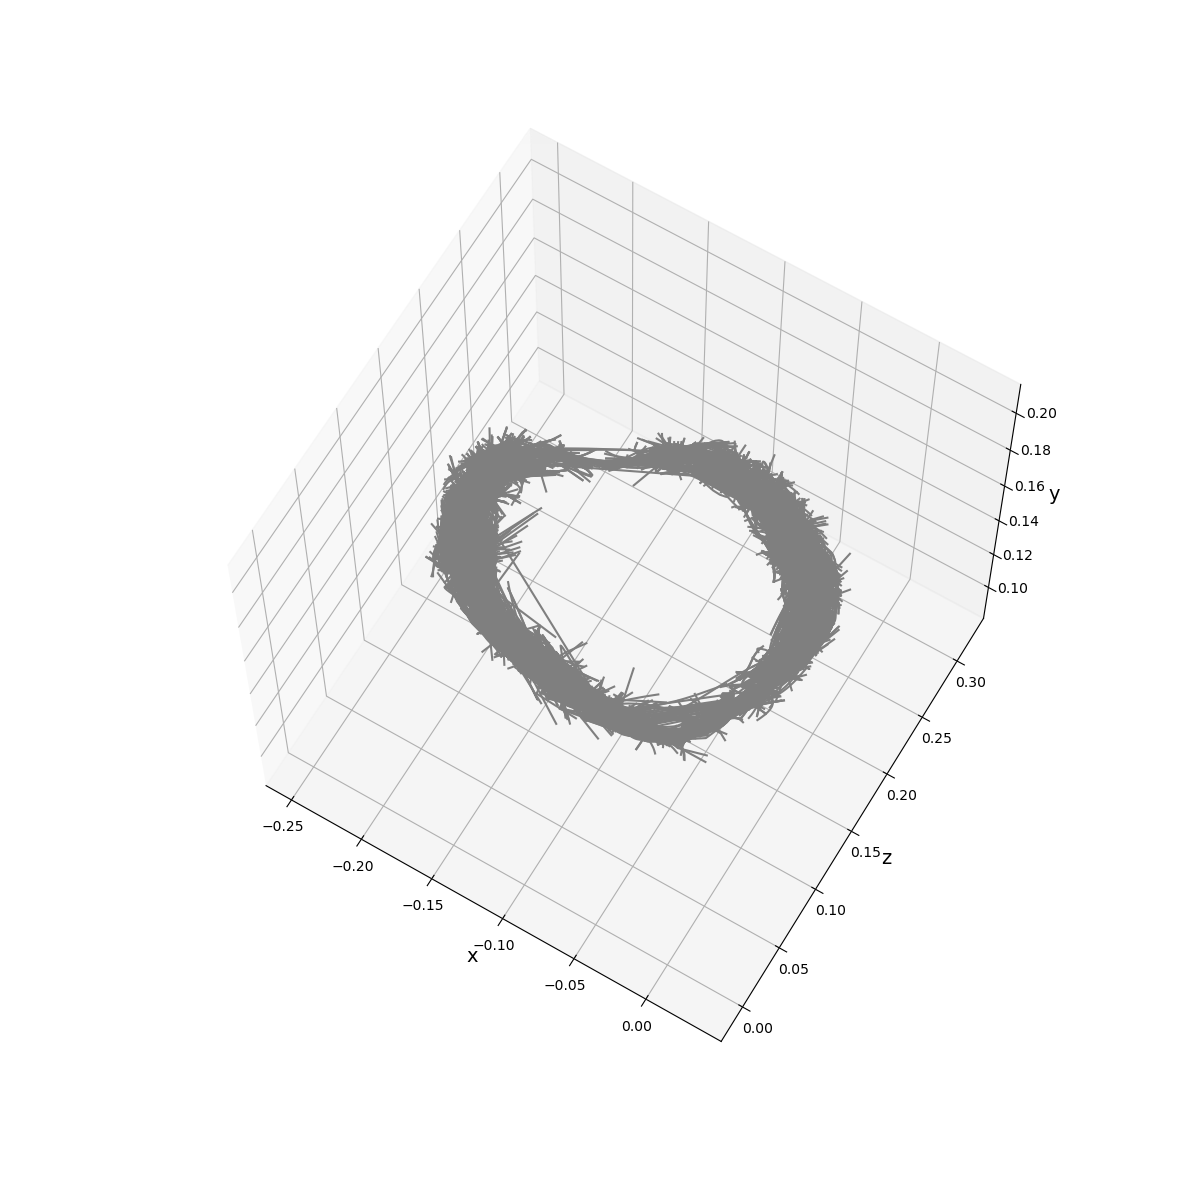

In [50]:
fig = plt.figure(figsize = (12, 12))
fig.patch.set_alpha(0.)
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')

# 軸ラベルを設定
ax.set_xlabel("x", size = 14)
ax.set_ylabel("z", size = 14)
ax.set_zlabel("y", size = 14)
ax.set_box_aspect((1,1,1))
#ax.set_xticks(np.arange(-4,4,1))
#ax.set_yticks(np.arange(-4,4,1))
#ax.set_zticks(np.arange(-2,9,1))

plot_graph()

In [174]:
import pickle
with open("postprocessing/curves_by/fixed/112_b20_s100_lmin40_lmax_100_o15_six_hole_leaf.curves","wb") as f:
    pickle.dump(curve_fragment, f)